# Group 061 Final Project : Traffic Collisions in San Diego

# Data Science Questions

What are the most dangerous places and times to drive throughout the year? More specifically, we are curious about which factors in particular can predict the likelihood of accidents occurring. We know there are probably certain factors that predict accident likelihood, listed below in the hypothesis, however we would like to see through our data analysis if there may be other factors that predict accident likelihood.

# Hypothesis
We believe that there are a number of factors that are likely to predict a higher probability of accidents in certain areas. These factors include:
- The time of day - Based on influences such as low visibility and drowsiness, it is likely that accidents are more likely to occur at night.
- Time of the year -  During the holidays there tends to be more people on the roads and increased instances of DUI, there is likely to be increased accidents during these times.
- Police presence - People tend to drive slower and more carefully around police cars and more diligent in obeying traffic laws. Therefore accidents, especially those involving traffic violations are less likely to occur in areas of higher police presence.
- Quality of road infrastructure - Indicators of bad road infrastructure and maintenance such as potholes or unclear or deteriorating road indicators and signs are likely to cause either confusion or loss of control while driving, therefore leading to increased instances of traffic collisions.
- Location - there are a number of effects of living or driving in a certain location whether it be the average age of the people in the group, the buildings in the area (day life and nightlife), and possibly the type of people who live in that area (single, married, family, young adults)


# Imports

In [161]:
import pandas as pd # DataFrames, Series
import numpy as np # Math Module
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
import datetime # Datetime 
from dateutil.parser import parse # String Conversion to Datetime
import folium # Folium Map
from folium import plugins # Folium Heatmap
from pygeocoder import Geocoder # Geocoding
import json # Reading JSON files
import re # Regular Expressions
from sklearn.cluster import KMeans # K Means Clustering for Location Data
from scipy.cluster.vq import whiten # Whiten datapoints
import matplotlib
from tqdm import tqdm_notebook as tqdm # Progress Bars
from scipy import stats # Statistical Tests

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 9)

# Reading Data

In [162]:
df = pd.read_csv('Datasets/pd_collisions_datasd_v1.csv')

In [163]:
df.head()

,report_id,date_time,police_beat,address_number_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
0,170082,2017-01-01 00:01:00,935,5500,,VALERIO,TRAIL,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
1,170101,2017-01-01 00:01:00,322,6400,,CRAWFORD,STREET,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
2,170166,2017-01-01 00:01:00,124,8300,,CAM DEL ORO,,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
3,170218,2017-01-01 00:01:00,325,8100,,ROYAL GORGE,DRIVE,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR
4,170097,2017-01-01 01:00:00,521,1000,,11TH,AVENUE,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR


# EDA

#### Dataset Description:

In this project, we are using the car collision dataset from San Diego Government Web Page. We are using their user-related data form 2017 to 2019. We use the data from all months to analysis the collision pattern within all counties of San Diego. 


The reason of why we chose this dataset is that this data set contains information of collisions from the whole San Diego City, which has a large amount of population for our analysis. Also, this dataset is an official dataset, which means that its information is relatively accurate.


The dataset includes 16 different features in a total of 28595 data entries.


*report_id* : The unique ID of the report of each accident.

*data_time* : The date and time of the accident.

*police_beat* : The territory and time that a police officer patrols.

*address_number_primary* : The primary address number.

*address_pd_primary* : The primary address direction (W/S/N/E).

*address_road_primary* : The primary road name.

*address_sfx_primary* & *address_pd_intersecting* & *address_name_intersecting* & *address_sfx_intersecting* : Other address information.

*violation_section* : California Vehicle Code Violations.

https://www.dmv.ca.gov/portal/dmv/?1dmy&urile=wcm:path:/dmv_content_en/dmv/dl/vioptct

*violation_type* : The Type of Violation (VC/PC/MC/ZZ/CO/HS)

*charge_desc* : The charge description, which descripts each charge. Based on the research, the description is based on the violation section.

*injured* : Number of injuries( Max: 180, Min: 0, Mean: 0.59 )

*killed* : Number of Death( Max: 3, Min: 0, Mean: 0.00465 )

*hit_run_lvl*: Level of severity if the collsion is a hit-run. (MISDEMEANOR/FELONY)


First, check the missingness of the dataset:

In [164]:
df.isnull().sum()/28595

report_id                    0.000000
date_time                    0.000000
police_beat                  0.000000
address_number_primary       0.000000
address_pd_primary           0.000000
address_road_primary         0.000000
address_sfx_primary          0.000140
address_pd_intersecting      0.000000
address_name_intersecting    0.000000
address_sfx_intersecting     0.000350
violation_section            0.000000
violation_type               0.000000
charge_desc                  0.000000
injured                      0.000000
killed                       0.000000
hit_run_lvl                  0.533905
dtype: float64

We noticed that there is a significant amount of missing values in hit_run_lvl, which is around 53.3905% of the total entries. Hence, we print out unique values of hit_run_lvl:

In [165]:
df.hit_run_lvl.unique()

array(['MISDEMEANOR', nan, 'FELONY'], dtype=object)

There are only three unique values, and two of them represent levels of severity of hit-run collisions, and the other one represents it is not a hit-run. Hence, its missing type is missing by design (MD). We should not impute it since it is designed to miss.

# Factor 1 - Location

## Extraction of Locations from Dataset

In [166]:
addresses = df.apply(lambda x : ' '.join(
    str(i).strip() for i in [x.address_number_primary, x.address_pd_primary, x.address_road_primary, x.address_sfx_primary] 
) + ', SAN DIEGO', axis = 1)

In [167]:
addresses.shape

(28595,)

## Geocoding

Since API calls take a lot of time, we would not want to make 28595 API calls every time we ran this notebook, so we delegated this task to an external file called `GeoEncoding.py` and saved all the data to `Datasets/locations.csv` so that this data is easily accessible.

In [168]:
locations = pd.read_csv('Datasets/locations.csv')['Coordinates'][:1000] # Not processing all points right now for time

# Cleaning invalid points
locations = locations[locations != '(-1, -1)']

In [169]:
LAT, LON = 0, 1 

def extract_latitude(x):
    return float(x[x.find('(') + 1 : x.find(',')])
def extract_longitude(x):
    return float(x[x.find(',') + 1 : x.find(')')])

center = np.mean(locations.apply(extract_latitude)), np.mean(locations.apply(extract_longitude))

center

(32.78095712560002, -117.14372668579998)

## Map

In [170]:
# Creating map
m = folium.Map(center, zoom_start = 11)

### Marking each point on map

In [171]:
for location in tqdm(locations):
    lat = float(location[location.find('(') + 1 : location.find(',') ])
    lon = float(location[location.find(',') + 1 : location.find(')') ])
    folium.CircleMarker([lat, lon],
                        radius = 15,
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)
m

We can see that there are certain areas that have more crashes than the others, for example, Downtown.

The next step would be to find out if this increase in crashes is significant. We can infer this from clustering our data points.

In [172]:
lats = locations.apply(extract_latitude)
lons = locations.apply(extract_longitude)

coords = np.array([lats, lons]).T
km = KMeans(n_clusters = 10, random_state = 0).fit(coords)

In [173]:
kmap = folium.Map(center, zoom_start = 11)

color_set = ['red', 'yellow', 'orange', 'green', 'blue', 'violet', 'pink', 'purple', 'black', 'grey']

for i in tqdm(range(len(locations))):
    folium.CircleMarker(
        (lats[i], lons[i]),
        radius = 10,
        color = color_set[km.labels_[i]]
    ).add_to(kmap)
kmap

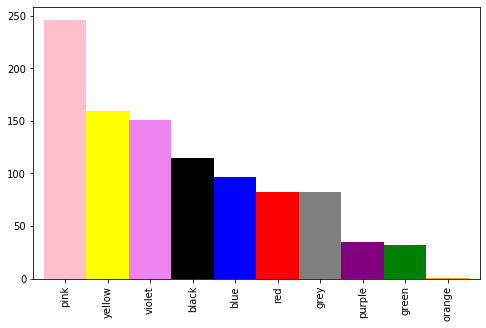

In [174]:
dist = pd.Series(km.labels_).apply(lambda x : color_set[x]).value_counts()
dist.plot(kind = 'bar', figsize = (8, 5), color = dist.index, width = 1)

It seems like the data does produce particular significantly different sized clusters at different reigons in the data. Thus, we can conclude that **Location is a significant factor in determining car crashes**.

# Factor 2  - Time of Year

## Extraction of Date from Dataset

*I was thinking for this chart we label the bottom axis by date or month/year something like that
Also I'd like to have a graph maybe like this one that shows average crashes per day on a given date maybe
then it would look a little more clean and be easier to show how crash frequency fluctuates throughout the year*

In [175]:
dates = pd.DataFrame(df['date_time'].apply(lambda s : map(int, parse(re.search(r'[0-9]{4}-[0-9]{2}-[0-9]{2}', s).group()).strftime('%m %d %W').split())).to_dict()).T.rename({
    0 : 'day',
    1 : 'month',
    2 : 'week_number',
}, axis = 1)

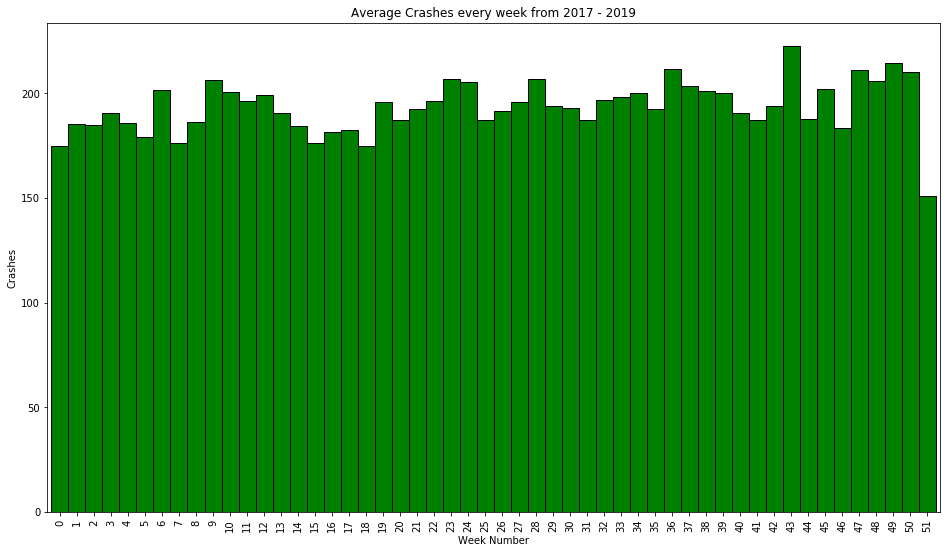

In [223]:
def dates_summary(d):
    d = d.copy()
    grouped = d.groupby('week_number').count()
    grouped.drop([0, 53], inplace = True)
    l = []
    
    for group in grouped.iterrows():
        if group[0] < 44:
            l.append(group[1]['day'] / 3)
        else:
            l.append(group[1]['day'] / 2)
    
    pd.Series(l).plot(kind = 'bar', color = 'green', edgecolor = 'black', figsize = (16,9), width = 1)
    plt.title('Average Crashes every week from 2017 - 2019')
    plt.ylabel('Crashes')
    plt.xlabel('Week Number')
    
    return pd.Series(l)
    
averages = dates_summary(dates)

## Hypothesis Testing

Now that we have the average crashes for our data, we need to check if date is a significant factor. We can use `scipy.stats.kstest` to confirm.

Our hypotheses will be :
$$
H_0 = \text{Our distribution is uniform} \\ 
H_a = \text{Our distribution is not uniform}
$$

We shall assume $\alpha = 0.05$

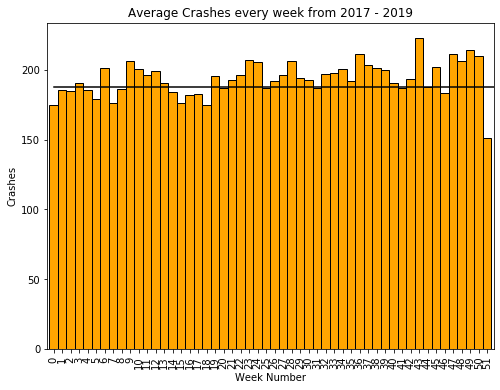

In [224]:
# Plotting against a uniform dist

x = np.linspace(stats.uniform.ppf(0), stats.uniform.ppf(1), 1000)
averages.plot(kind='bar', color = 'orange', width = 1, edgecolor = 'black', figsize = (8, 6))
plt.plot(x * 53, stats.uniform.pdf(x) * 187.61728395061726, color = 'black')
plt.title('Average Crashes every week from 2017 - 2019')
plt.ylabel('Crashes')
plt.xlabel('Week Number')  
pass

In [225]:
ks_stat, p_value = stats.kstest(averages, 'uniform')
print(f'P-Value : {p_value}')

P-Value : 0.0


Since our p value is less than our $\alpha = 0.05$, we can reject $H_0$ in favor of $H_a$. Therefore, we can conclude __Time of Year is a significant determinant of Car Crashes__.

# Factor 3 - The Time of Day

## Crashes Per Minute

FIrst, we will group the dataframe by hours and minutes to see if there are any significantly high or low counts during any specific time periods.

In [62]:
# convert the "data_time" column to data-time object
times = pd.to_datetime(df.date_time)
df_td = df.copy()
df_td.date_time = times

Text(0, 0.5, 'Number of Crashes')

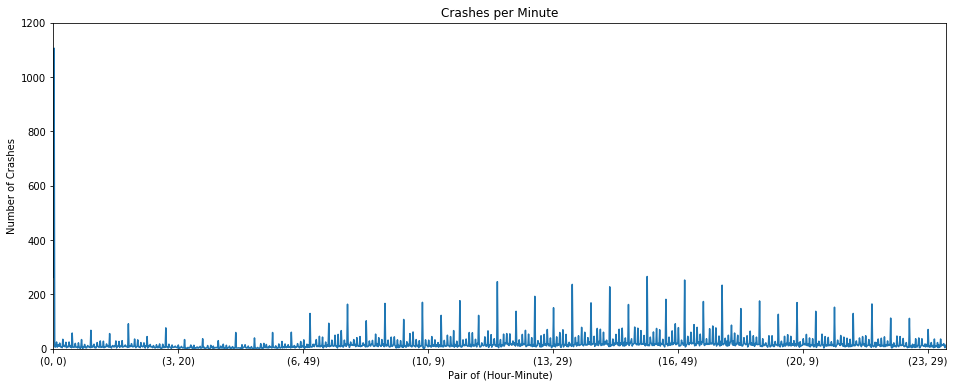

In [76]:
# group the dataframe by hour and minutes in data_time column
grp = df_td.groupby(by=[df_td.date_time.map(lambda x : (x.hour,x.minute))])
# get counts
df_grp_minute = grp.count()
df_grp_minute = df_grp_minute[df_grp_minute.columns[:1]]

# graph the dataframe to visualize the number of crashed per minute
df_grp_minute.report_id.plot(kind='line', figsize=(16,6)).set_ylim(0,1200)
plt.title('Crashes per Minute')
plt.xlabel('Pair of (Hour-Minute)')
plt.ylabel('Number of Crashes')

We noticed a significantly high amount of car crashed happening around 1 AM, with a value of 1106. The information does not make sense since it has a huge gap comparing to other time periods. 

We decide to mark it as an outliers. One potential reason is that Midnight is the default time. While one accident does not a time label, then its data-time will be set to that day's midnight. Hence, we decide to drop the 12:00 AM and 12:01 AM Entries.

Text(0, 0.5, 'Number of Crashes')

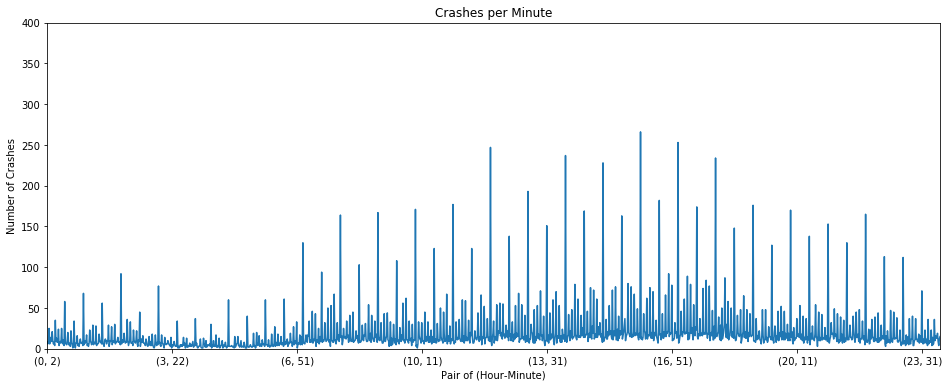

In [77]:
# drop entries around midnight
df_grp_minute_drop = df_grp_minute.drop(df_grp_minute.index[[0,1]])

# graph the dataframe to visualize the number of crashed per minute
df_grp_minute_drop.report_id.plot(kind='line', figsize=(16,6)).set_ylim(0,400)
plt.title('Crashes per Minute')
plt.xlabel('Pair of (Hour-Minute)')
plt.ylabel('Number of Crashes')

When we look at the dataset, we noticed that there are many extreme values in each hour. One potential reason is that during many circumstances, police did not record the very specific time of the accident. Hence, they will only record hour in the file without minutes. This is why the the crashed at the beginning of each hour is very high. 

Based on this, we believe group by minutes and hours is not the best approach. We decide to group by hours and see the crashed per hour in a day.

## Crashes Per Hour

After, we group the dataframe by ONLY hours to visualize the amount of car crushed in different time periods in a day.

In [52]:
# define a method to drop all entries around midnight first
def drop_midnight(row):
    if '00:00:00' in row.date_time or '00:01:00' in row.date_time:
        return True
    return False

# apply method on the dataframe to drop these entries
l = df.apply(drop_midnight,axis = 1)
df_after_drop = df_td.drop(df_td[l].index)

# convert the "data_time" column to data-time object
times_minute = pd.to_datetime(df_after_drop.date_time)
df_after_drop.date_time = times_minute

In [61]:
df_after_drop.head()

,report_id,date_time,police_beat,address_number_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
4,170097,2017-01-01 01:00:00,521,1000,,11TH,AVENUE,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR
5,170220,2017-01-01 01:00:00,524,1000,,A,STREET,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
6,170153,2017-01-01 01:18:00,437,2600,,RAMFOS,PLACE,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,NaN
7,170035,2017-01-01 01:53:00,935,3900,,DE LA VALLE,,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR
8,170044,2017-01-01 01:58:00,115,9100,,SYDNEY,COURT,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR


Text(0, 0.5, 'Number of Crashes')

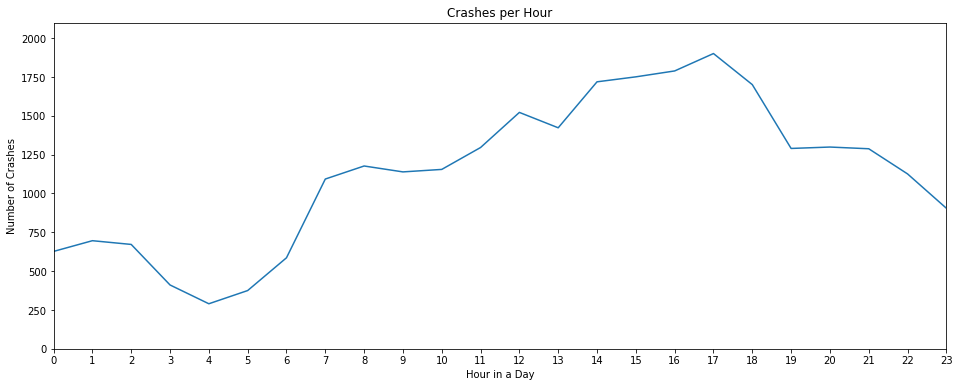

In [78]:
# group the dataframe by hours in data_time column
grp = df_after_drop.groupby(by=[df_after_drop.date_time.map(lambda x : (x.hour))])
# get counts
df_grp = grp.count()
df_grp = df_grp[df_grp.columns[:1]]

# graph the dataframe to visualize the number of crashed per hour
df_grp.report_id.plot(kind='line', figsize=(16,6)).set_ylim(0,2100)
ticks = plt.xticks(np.arange(0, 24, 1.0))
plt.title('Crashes per Hour')
plt.xlabel('Hour in a Day')
plt.ylabel('Number of Crashes')

Based on the result of our visualization, we noticed that the number of crashes is very high in the afternoon and reaches maximum around 5 PM. Potential reason of this is the afternoon is traffic peak-hour, that people will drive home from work. After 5 PM, the number of crashed will decrease as the time pass and reach its minimum around 4 AM in the morning, that it is resonable since not many people drive during the early morning.